## Perguntas do negócio

Marcus:
* Qual a distribuição dos valores de postagem?
* Qual a média de postagem e o ticket médio por cliente?
* Qual a distribuição de postagem por mês, dia e dia da semana?
* Qual o ticket médio por cliente e tipo de serviço?
* O valor médio do serviço "EXPRESSO" é significativamente diferente do valor médio do serviço "ECONÔMICO"?

---
Thiago:
* A média de postagens na Segunda-Feira é significativamente diferente da média de postagens no restante da semana?
* A média de postagens nos primeiros 15 dias é significativamente diferente da média de postagens no restante do mês?

---
Gabriel:
* Plotar a distribuição de postagem por estados
* A média de postagens para MG é significativamente diferente que a média de postagens de SP?

---
Ruann:
*   O ticket médio da região Norte é significativamente diferente do ticket médio da região Nordeste?




## Thiago
---

### * A média de postagens na Segunda-Feira é significativamente diferente da média de postagens no restante da semana?


### * Valor medio do numero de postagens entre um determinado range de precos é maior que outro valor

### * A média de postagens nos primeiros 15 dias é significativamente diferente da média de postagens no restante do mês?

### Primeiro realiza-se a importação das bibliotecas necessárias e a importação do banco de dados

In [2]:
# from google.colab import drive utilizado para 
# drive.mount('/content/drive') processos utilizados para utilizar os recursos do drive no collab
import pandas as pd
import os
import locale
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import datetime

warnings.filterwarnings("ignore")




### Nesse caso os dados serão carregados localmente para viabilizar a reprodutibilidade do projeto, mesmo que o fluxo de trabalho tenha sido realizado no colab

In [3]:
# df = pd.read_parquet(r'/content/drive/MyDrive/Coders_Estatistica/operations_base.parquet') caminho utilizado no drive

# necessário instalar pyarrow e fastparquet
df = pd.read_parquet(r'operations_base.parquet') # arquivo geral
df.head() # 




,Data,Objeto,CEP,Serviço,Valor,Cliente,Postagem,Destino,UF
0,02/01/2023,QW184224840RJ,27143610,EXPRESSO,13.56,MANCHETE,MANUAL,RIO DE JANEIRO,RJ
1,02/01/2023,QW184224874RJ,26160210,EXPRESSO,7.28,MANCHETE,MANUAL,RIO DE JANEIRO,RJ
2,02/01/2023,QW184224868RJ,23535370,EXPRESSO,7.28,MANCHETE,MANUAL,RIO DE JANEIRO,RJ
3,02/01/2023,QW184224893RJ,27321640,EXPRESSO,13.56,MANCHETE,MANUAL,RIO DE JANEIRO,RJ
4,02/01/2023,QW184227030RJ,23530816,EXPRESSO,7.28,MANCHETE,MANUAL,RIO DE JANEIRO,RJ


### Lendo o arquivo parquet utilizando a funcao do pandas

In [4]:
df_thiago = pd.read_parquet(r'operations_base.parquet')

### Fazendo o tratamento de dados para incluir na tabela o dia da semana correspondente

In [32]:
df_thiago["Data"] = pd.to_datetime(df_thiago["Data"], dayfirst=True)

df_thiago['Dia da Semana'] = [valor.weekday() for valor in df_thiago['Data']]
dias_da_semana = {0: 'Segunda-feira', 1: 'Terça-feira', 2: 'Quarta-feira', 3: 'Quinta-feira', 4: 'Sexta-feira', 5: 'Sábado', 6: 'Domingo'}

df_thiago['Dia da Semana'] = df_thiago['Dia da Semana'].map(dias_da_semana)

df_thiago["Dia da Semana"].unique()

array(['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira',
       'Sexta-feira'], dtype=object)

### Agora vamos identificar quantos produtos foram vendidos por dia de semana e visualizar isso em um gráfico para tentar visualizar se segunda possui mais ocorrências que o resto.

In [33]:
gb_dia_mes_ano = df_thiago.groupby("Dia da Semana")
quantidade_por_dia = gb_dia_mes_ano["Data"].agg(["count"]).reset_index()
quantidade_por_dia.rename(columns={"count" : "Quantidade de Produtos"}, inplace=True)
quantidade_por_dia

,Dia da Semana,Quantidade de Produtos
0,Quarta-feira,168553
1,Quinta-feira,151385
2,Segunda-feira,223042
3,Sexta-feira,137498
4,Terça-feira,167912


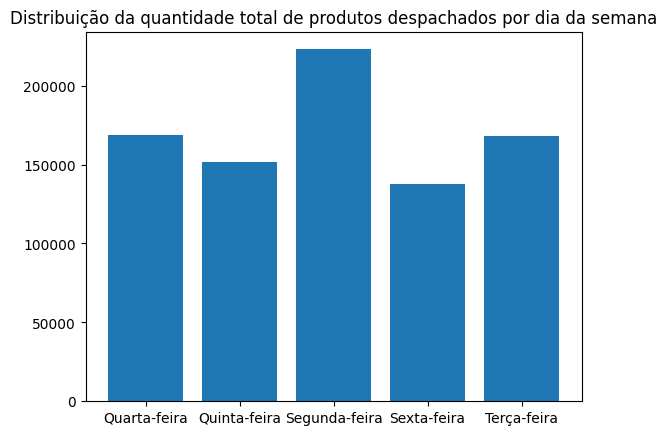

In [94]:
plt.figure()
plt.title("Distribuição da quantidade total de produtos despachados por dia da semana")
plt.bar(quantidade_por_dia["Dia da Semana"], quantidade_por_dia["Quantidade de Produtos"])
plt.show()

### Observamos que a quantidade total de produtos postados na segunda feira é consideravelmente maior que o resto dos dias. Consideraremos agora as médias diárias.

In [100]:
gb_quantidade_dias = df_thiago.groupby("Dia da Semana")["Data"].nunique()
gb_quantidade_dias["Quarta-feira"]

38

In [102]:
dict_produtos_por_dia_da_semana = {dia: df_thiago[df_thiago["Dia da Semana"] == dia]["Data"].count() for dia in df_thiago["Dia da Semana"].unique()}
dict_produtos_por_dia_da_semana

{'Segunda-feira': 223042,
 'Terça-feira': 167912,
 'Quarta-feira': 168553,
 'Quinta-feira': 151385,
 'Sexta-feira': 137498}

In [103]:
media_quantidade_dia_da_semana = {dia : round(dict_produtos_por_dia_da_semana[dia]/gb_quantidade_dias[dia], 2) for dia in dict_produtos_por_dia_da_semana.keys()}
media_quantidade_dia_da_semana

{'Segunda-feira': 6028.16,
 'Terça-feira': 4538.16,
 'Quarta-feira': 4435.61,
 'Quinta-feira': 4205.14,
 'Sexta-feira': 3928.51}

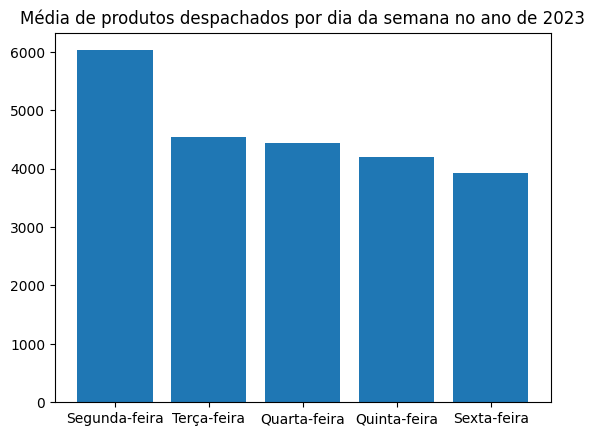

In [104]:
plt.figure()
plt.title("Média de produtos despachados por dia da semana no ano de 2023")
plt.bar(media_quantidade_dia_da_semana.keys(), media_quantidade_dia_da_semana.values())
plt.show()

### Nessa visualização podemos afirmar que, pelo menos no ano de 2023, existe uma tendência de existirem mais produtos despachados na segunda. Por conclusão prática, entende-se que essa maior frequência dos produtos vem do fato das encomendas do fim de semana se acumularem na segunda feira.

In [16]:


gb_dia = df_thiago.groupby("Dia da Semana")
media_val_dias_da_semana = gb_dia["Valor"].agg(["mean"]).reset_index()
media_val_dias_da_semana.rename(columns={"mean" : "Média dos Valores"}, inplace=True)
media_val_dias_da_semana

,Dia da Semana,Média dos Valores
0,Quarta-feira,22.693718
1,Quinta-feira,22.845689
2,Segunda-feira,25.042852
3,Sexta-feira,25.387627
4,Terça-feira,23.892965


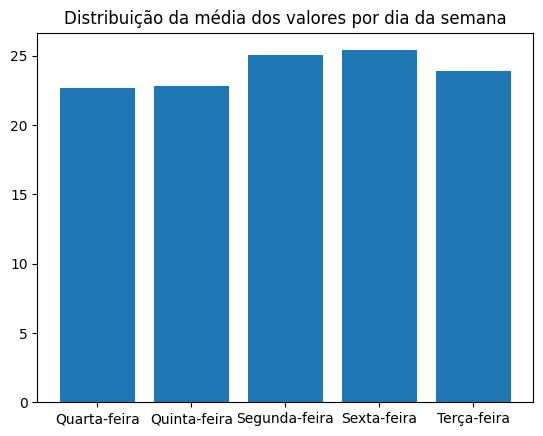

In [17]:
plt.figure()
plt.title("Distribuição da média dos valores por dia da semana")
plt.bar(media_val_dias_da_semana["Dia da Semana"], media_val_dias_da_semana["Média dos Valores"])
plt.show()


In [ ]:
gb_dia = df_thiago.groupby("Dia da Semana")
media_quantidade_produtos_dias_da_semana = gb_dia["Valor"].agg(["mean"]).reset_index()
media_quantidade_produtos_dias_da_semana.rename(columns={"mean" : "Média dos Valores"}, inplace=True)
media_quantidade_produtos_dias_da_semana



In [8]:
gb_dia = df_thiago.groupby("Dia da Semana")
somatorio_val_dias_da_semana = gb_dia["Valor"].agg(["sum"]).reset_index()
somatorio_val_dias_da_semana.rename(columns={"sum" : "Soma dos Valores"}, inplace=True)
somatorio_val_dias_da_semana

,Dia da Semana,Soma dos Valores
0,Quarta-feira,3825094.28
1,Quinta-feira,3458494.58
2,Segunda-feira,5585607.88
3,Sexta-feira,3490747.92
4,Terça-feira,4011915.53


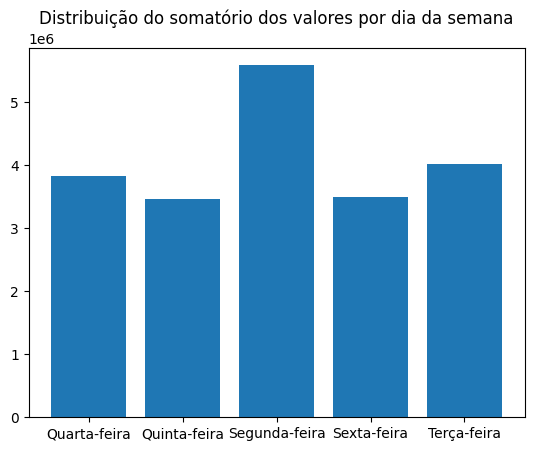

In [12]:
plt.figure()
plt.title("Distribuição do somatório dos valores por dia da semana")
plt.bar(somatorio_val_dias_da_semana["Dia da Semana"], somatorio_val_dias_da_semana["Soma dos Valores"])
plt.show()

### Queremos determinar se a média de postagens na segunda feira é significativamente diferente da média do resto da semana

In [22]:
df["Data"] = pd.to_datetime(df["Data"], dayfirst=True)
timeline_postagem = df.groupby('Data')['Objeto'].count()
timeline_postagem = timeline_postagem.sort_index()

faturamento = df.groupby('Data')['Valor'].sum()

servicos = df.Serviço.unique()
postagem = df.Postagem.unique()
destino = df.Destino.unique()

servico_counts = {}
postagem_counts = {}
destino_counts = {}
triagem_counts = {}

for i in servicos:
    servico_counts[i] = df.loc[df['Serviço'] == i].groupby('Data')['Serviço'].count()

for i in postagem:
    postagem_counts[i] = df.loc[df['Postagem'] == i].groupby('Data')['Postagem'].count()

for i in destino:
    destino_counts[i] = df.loc[df['Destino'] == i].groupby('Data')['Destino'].count()


df_servico = pd.DataFrame(servico_counts).reset_index()
df_postagem = pd.DataFrame(postagem_counts).reset_index()
df_destino = pd.DataFrame(destino_counts).reset_index()

df_servico.rename(columns={'index': 'Data'}, inplace=True)
df_postagem.rename(columns={'index': 'Data'}, inplace=True)
df_destino.rename(columns={'index': 'Data'}, inplace=True)

df_merged  = df_servico.merge(df_postagem, on='Data', how='outer')
df_merged = df_merged.merge(df_destino, on='Data', how='outer')
df_merged.fillna(0, inplace=True)

df_merged["Dia"] =[valor.day for valor in df_merged['Data']]
df_merged["Mes"] =[valor.month for valor in df_merged['Data']]

df_somatorio_por_mes = df_merged.groupby('Mes').sum()
df_somatorio_por_dia = df_merged.groupby('Dia').sum()

colunas = ['EXPRESSO', 'ECONÔMICO', 'MANUAL', 'AUTOMÁTICO', 'RIO DE JANEIRO', 'OUTROS ESTADOS']

for coluna in colunas:
    df_merged[f'{coluna}_Cumulativa'] = df_merged[coluna].cumsum()

df_somatorio_por_mes['Total de Objetos'] = df_somatorio_por_mes['EXPRESSO'] + df_somatorio_por_mes['ECONÔMICO']
df_somatorio_por_dia['Total de Objetos'] = df_somatorio_por_dia['EXPRESSO'] + df_somatorio_por_dia['ECONÔMICO']

df_merged['Dia da Semana'] = [valor.weekday() for valor in df_merged['Data']]
dias_da_semana = {0: 'Segunda-feira', 1: 'Terça-feira', 2: 'Quarta-feira', 3: 'Quinta-feira', 4: 'Sexta-feira', 5: 'Sábado', 6: 'Domingo'}

df_merged['Dia da Semana'] = df_merged['Dia da Semana'].map(dias_da_semana)


TypeError: datetime64 type does not support sum operations

In [14]:
df_merged["Dia da Semana"].unique()

NameError: name 'df_merged' is not defined

In [ ]:
df_merged.describe()

,EXPRESSO,ECONÔMICO,MANUAL,AUTOMÁTICO,RIO DE JANEIRO,OUTROS ESTADOS,Dia,Mes,EXPRESSO_Cumulativa,ECONÔMICO_Cumulativa,MANUAL_Cumulativa,AUTOMÁTICO_Cumulativa,RIO DE JANEIRO_Cumulativa,OUTROS ESTADOS_Cumulativa
count,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,2278.000000,2358.010929,2745.874317,1890.136612,2250.699454,2385.311475,15.633880,4.967213,193312.721311,196875.868852,236554.431694,153634.158470,188258.551913,201930.038251
std,900.190798,1129.216606,999.476473,1445.801420,1140.249357,898.770110,8.760698,2.541743,110326.581570,126007.126461,134408.168719,102495.532119,117503.540616,118742.159517
min,814.000000,482.000000,1086.000000,5.000000,642.000000,1071.000000,1.000000,1.000000,2242.000000,482.000000,2719.000000,5.000000,789.000000,1935.000000
25%,1630.000000,1553.500000,1924.500000,956.000000,1451.000000,1745.500000,8.000000,3.000000,105854.500000,80919.500000,133367.500000,53406.500000,81262.500000,105511.500000
50%,2070.000000,2131.000000,2709.000000,1470.000000,2053.000000,2166.000000,15.000000,5.000000,179340.000000,197942.000000,219756.000000,157526.000000,192424.000000,184858.000000
75%,2737.000000,2913.500000,3379.500000,2422.000000,2729.000000,2812.500000,23.000000,7.000000,286633.500000,304444.500000,336407.000000,254671.000000,284635.500000,306442.500000
max,5407.000000,6900.000000,6238.000000,7086.000000,7069.000000,5847.000000,31.000000,9.000000,416874.000000,431516.000000,502495.000000,345895.000000,411878.000000,436512.000000


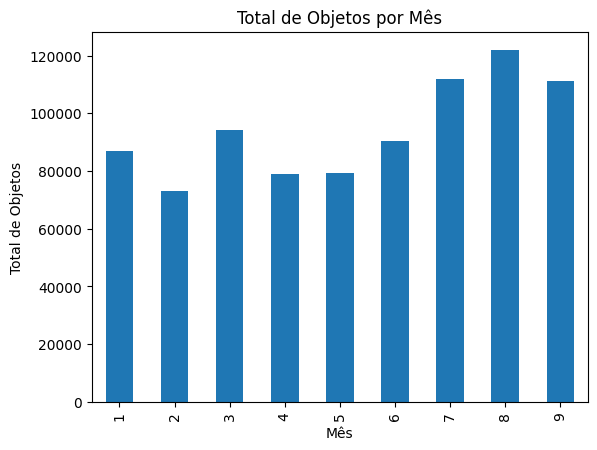

In [ ]:
df_somatorio_por_mes['Total de Objetos'].plot(kind='bar', xlabel='Mês', ylabel='Total de Objetos', title='Total de Objetos por Mês')
plt.show()

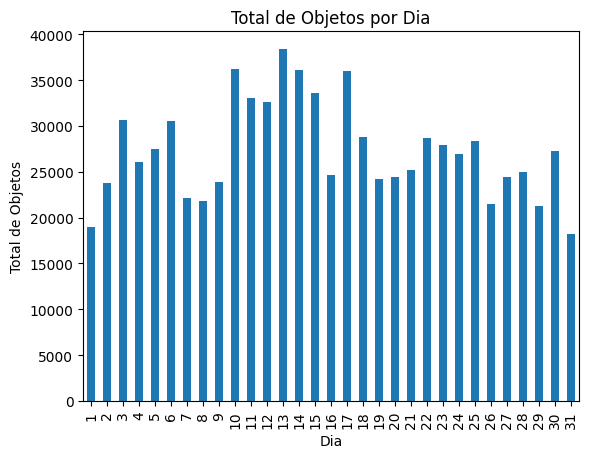

In [ ]:
df_somatorio_por_dia['Total de Objetos'].plot(kind='bar', xlabel='Dia', ylabel='Total de Objetos', title='Total de Objetos por Dia')
plt.show()

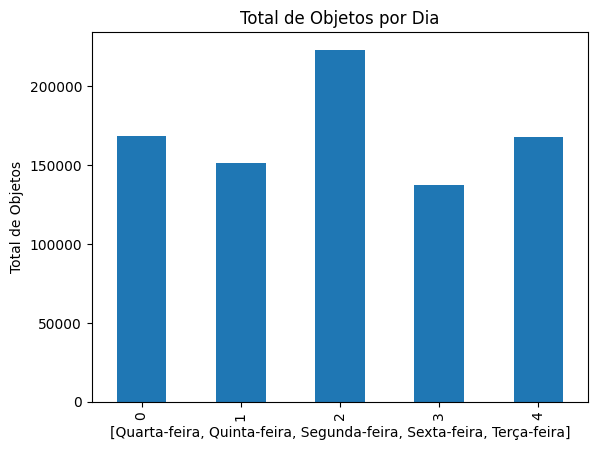

In [ ]:
soma_por_dia = df_merged.groupby('Dia da Semana').sum().reset_index()
soma_por_dia['Total de Objetos'] = soma_por_dia['EXPRESSO'] + soma_por_dia['ECONÔMICO']
soma_por_dia['Total de Objetos'].plot(kind='bar', xlabel=soma_por_dia['Dia da Semana'], ylabel='Total de Objetos', title='Total de Objetos por Dia')
plt.show()

In [ ]:
expresso = df[df['Serviço'] == 'EXPRESSO']['Valor']
outro_servico = df[df['Serviço'] != 'EXPRESSO']['Valor']

t_stat, p_value = stats.ttest_ind(expresso, outro_servico)

if p_value < 0.05:
    print(f"Há evidências para rejeitar a hipótese nula - {p_value}")
else:
    print(f"Não há evidências para rejeitar a hipótese nula - {p_value}")

df = df.loc[df['Data'] != '2023-09-15']
df = df.loc[df['Data'] != '2023-09-18']

Há evidências para rejeitar a hipótese nula - 0.0


In [ ]:
media_valores_ordenados=np.mean(df['Valor'])
mediana_valores_ordenados = np.median(df['Valor'])
moda_valores_ordenados = stats.mode(df['Valor'])


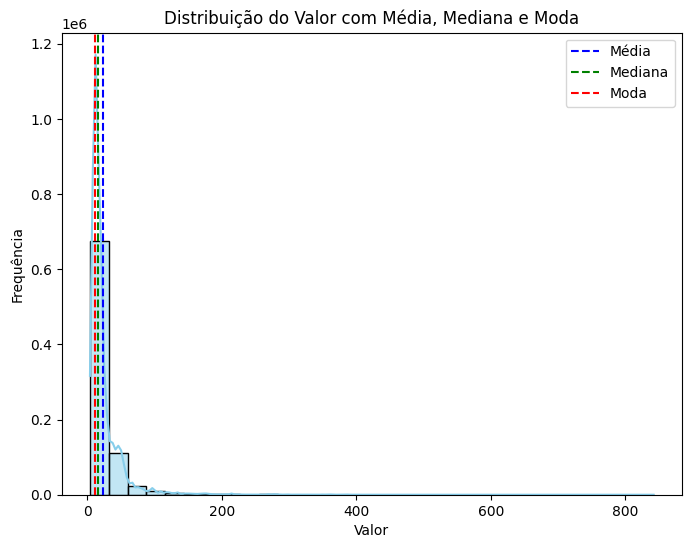

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df['Valor'], bins=30, kde=True, color='skyblue')
plt.axvline(x=media, color='blue', linestyle='--', label='Média')
plt.axvline(x=mediana, color='green', linestyle='--', label='Mediana')
plt.axvline(x=moda, color='red', linestyle='--', label='Moda')
plt.legend()
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.title('Distribuição do Valor com Média, Mediana e Moda')
plt.show()
